Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import EarlyStopping


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path('./Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset='training',
                                                              batch_size=batch_size,seed=123,image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split =0.2,subset ='validation' ,
                                                             batch_size=batch_size,seed=123,image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

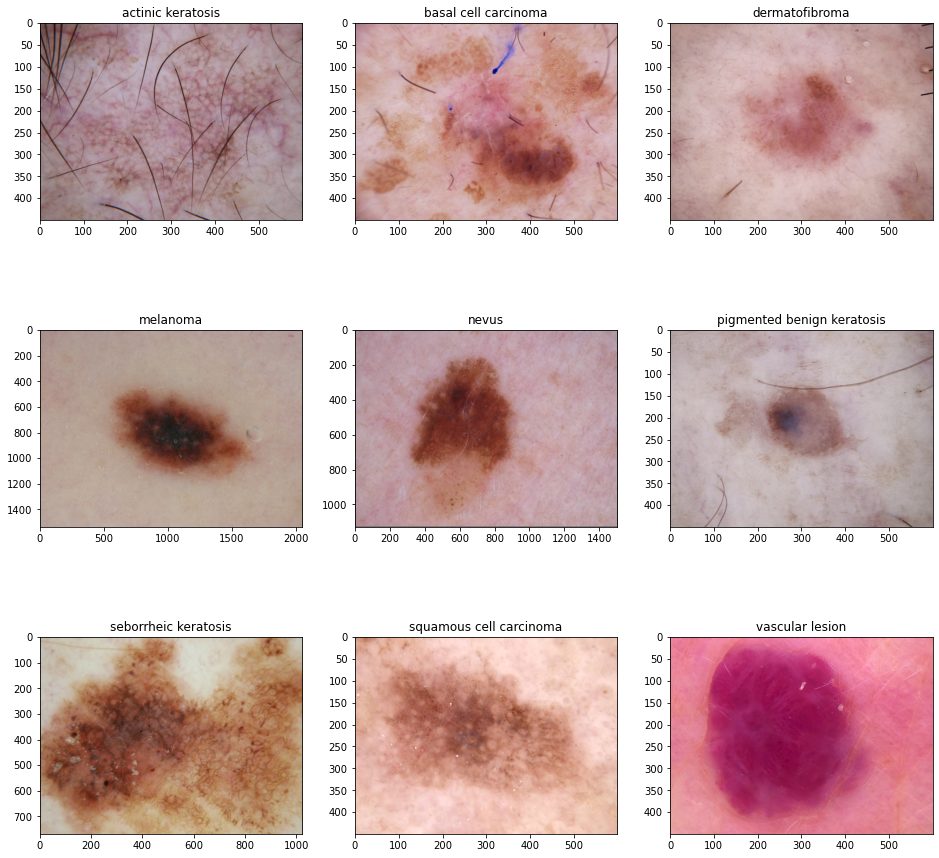

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 
               'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
plt.figure(figsize=(16,16))

for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+"/*.jpg"))[1]))
    plt.imshow(image)
    plt.title(class_names[i])
    
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Conv2D,Dense,Activation,BatchNormalization,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.regularizers import l2
num_classes=9

In [12]:
model = Sequential([layers.experimental.preprocessing.Rescaling(scale=1./255)])
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.build(input_shape=(None,180,180,3))

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 88, 88, 32)        0         
                                                        

### Train the model

In [15]:
epochs = 20
es = EarlyStopping(monitor='val_loss',mode='min',patience=10)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es]
)

Epoch 1/20


C:\Users\idhay\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 39s 584ms/step - loss: 1.9969 - accuracy: 0.2210 - val_loss: 1.8231 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 31s 556ms/step - loss: 1.7760 - accuracy: 0.3376 - val_loss: 1.6907 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 29s 526ms/step - loss: 1.7136 - accuracy: 0.3577 - val_loss: 1.6921 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 30s 534ms/step - loss: 1.6008 - accuracy: 0.4280 - val_loss: 1.6692 - val_accuracy: 0.4385
Epoch 5/20
56/56 [==============================] - 33s 597ms/step - loss: 1.5554 - accuracy: 0.4464 - val_loss: 1.5177 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 33s 584ms/step - loss: 1.4937 - accuracy: 0.4693 - val_loss: 1.4541 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 35s 630ms/step - loss: 1.4425 - accuracy: 0.4900 - val_loss: 1.5986 - val_accuracy: 0.4183
Epoch 8/20

### Visualizing training results

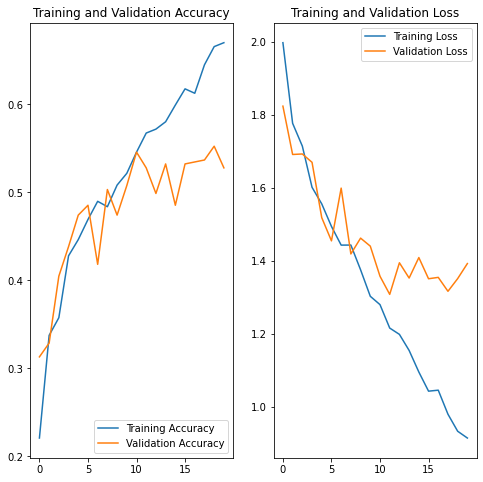

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion 1
The validation accuracy has been stable after 10 epocs, however the training accuracy increases.The model is overfit after about 10 epochs.

### Data augmentation

In [17]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomCrop(200,250),
    layers.RandomWidth(factor=(0.2, 0.3)),
    layers.RandomContrast(factor=(0.2, 0.3))
])

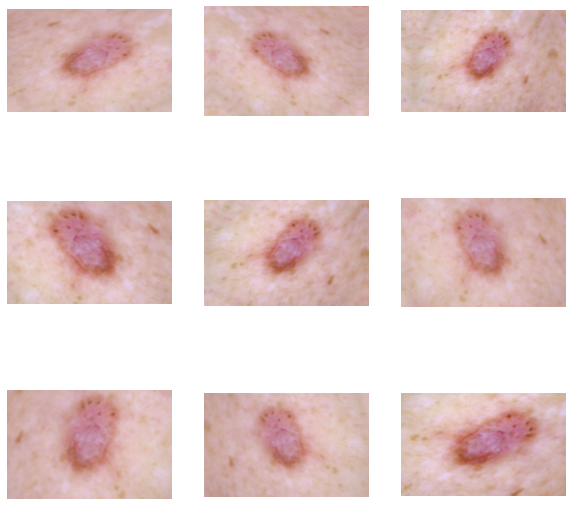

In [18]:
plt.figure(figsize=(10,10))

for images,_ in train_ds.take(4):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")


### Create the model, compile and train the model


In [19]:
model = Sequential([data_augmentation,
                    layers.Resizing(img_height,img_width),
                    layers.experimental.preprocessing.Rescaling(scale=1./255)])
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None,180,180,3))

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
es = EarlyStopping(monitor='val_loss',mode='min',patience=10)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es]
)

Epoch 1/30
56/56 [==============================] - 39s 683ms/step - loss: 2.0420 - accuracy: 0.2059 - val_loss: 1.9046 - val_accuracy: 0.2975
Epoch 2/30
56/56 [==============================] - 36s 647ms/step - loss: 1.8441 - accuracy: 0.3008 - val_loss: 1.7173 - val_accuracy: 0.3736
Epoch 3/30
56/56 [==============================] - 46s 816ms/step - loss: 1.6866 - accuracy: 0.3739 - val_loss: 1.6317 - val_accuracy: 0.4094
Epoch 4/30
56/56 [==============================] - 42s 759ms/step - loss: 1.6947 - accuracy: 0.3834 - val_loss: 1.5802 - val_accuracy: 0.4474
Epoch 5/30
56/56 [==============================] - 36s 636ms/step - loss: 1.5450 - accuracy: 0.4280 - val_loss: 1.5125 - val_accuracy: 0.4497
Epoch 6/30
56/56 [==============================] - 37s 663ms/step - loss: 1.5033 - accuracy: 0.4453 - val_loss: 1.5620 - val_accuracy: 0.4407
Epoch 7/30
56/56 [==============================] - 41s 740ms/step - loss: 1.4787 - accuracy: 0.4654 - val_loss: 1.4347 - val_accuracy: 0.4922

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The model performance is similar to the previous model after data augmentation. However overfitting is addressed in the current model.

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
for i in range(9):
    data_dir_train = pathlib.Path("./Train/"+class_names[i])
    image_count = len(list(data_dir_train.glob('*.jpg')))
    print(class_names[i],image_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? seborrheic keratosis has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples? Pigmented benign keratosis dominates the sample population


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import glob
data_dir_train="./Train"
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*/*.jpg'))]
path_list

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*/*.jpg'))]


In [ ]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [ ]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

In [ ]:
path_to_training_dataset="./Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
data_dir_train =  pathlib.Path("./Train")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [ ]:
data_dir_train="./Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height,img_width),
  batch_size=batch_size)

#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### Create your model

In [ ]:
model = Sequential([layers.Resizing(img_height,img_width),
                    layers.experimental.preprocessing.Rescaling(scale=1./255)])
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None,180,180,3))

#### Train your model

In [ ]:
epochs = 50
es = EarlyStopping(monitor='val_loss',mode='min',patience=10)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es]
)

#### Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Did you get rid of underfitting/overfitting? Did class rebalance help?



Class Rebalance helped in achieving the high accuracy compared to previous two models. There seems to be a slight overfitting of data